In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import util
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from sklearn.metrics import r2_score

# Load data
data_folder = '../data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lagrangian Approaches for Constrained ML

## Constrained Machine Learning

**Let's consider ML problems with _constrained output_**

In particular, let's focus on problems in the form:
$$
\text{argmin}_{\theta} \left\{ L(y) \mid g(y) \leq 0 \right\} \text{ with: } y = f(\hat{x}, \omega)
$$
Where:
* $L$ is the loss
* $\hat{x}$ is the training input
* $y$ is the ML model output, i.e. $f(x, \omega)$
* $\omega$ is the parameter vector (we assume a parameterized model)
* $g$ is a constraint function

Equality csts. can be viewed as double-inequalities (but they admit simplifications)


## Lagrangian Relaxations for Constrained ML

**One way to deal with this problem is to rely on a _Lagrangian Relaxation_**

Main idea: we turn the constraints into _penalty terms_:
$$
\text{argmin}_{\theta} L(y) + \lambda^T \max(0, g(y)) \quad \text{ with: } y = f(\hat{x}, \omega)
$$
Or, alternatively:
$$
\text{argmin}_{\theta} L(y) + \lambda^T \max(0, g(y))^2 \quad \text{ with: } y = f(\hat{x}, \omega)
$$

* We use a vector of _multipliers_ $\lambda$ to weight the constraint violations

**This is a popular approach for ML with constraints**

* One of the first occurrences as [Semantic Based Regularization](https://www.sciencedirect.com/science/article/pii/S0004370215001344)
* The constraints are "distilled" in the model parameters



## Lagrangian Relaxations for Constrained ML

**Equality constraints can be treated as double inequalities**

...Or via the simplified form:
$$
\arg\min_{\theta} \left\{ L(y) + \lambda^T g(y)^2 \right\} \text{ with: } y = f(\hat{x}; \theta)
$$

**Intuitively, for a large enough $\lambda$ it should be possible to approach feasibility**

* It will be _approximate_ in general
* Any guarantee will apply only to the training set

...But we get our constraints!

## A Case Study: Fairness in ML Models

**As a case study, say we want to estimate the risk of violent crimes**

<center><img src="assets/minority-report.jpg" width=800px/></center>

* This is obviously a very _ethically sensitive (and questionable) task_
* Our model may easily end up discriminating some social groups

## Loading and Preparing the Dataset

**We will start by loading the ["crime" UCI dataset](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)**

We will use a pre-processed version:

In [3]:
data = util.load_communities_data(data_folder)
attributes = data.columns[3:-1]
target = data.columns[-1]
data.head()

,communityname,state,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
1008,EastLampetertownship,PA,5,11999,0,0.1203,0.2544,0.1208,0.1302,0.5776,...,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000,147.49
1271,EastProvidencecity,RI,6,50380,0,0.1171,0.2459,0.1159,0.1660,1.0000,...,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000,150.88
1936,Betheltown,CT,9,17541,0,0.1356,0.2507,0.1138,0.0804,0.8514,...,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000,95.47
1601,Crowleycity,LA,8,13983,0,0.1506,0.2587,0.1234,0.1302,0.0000,...,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000,1029.02
293,Pawtucketcity,RI,2,72644,0,0.1230,0.2725,0.1276,0.1464,1.0000,...,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103,458.28


The target is "violentPerPop" (number of violent offenders per 100K people)

## Loading and Preparing the Dataset

**We prepare for normalizing all numeric attributes**

* The only categorical input is "race" (0 = primarily "white", 1 = primarily "black")
* Incidentally, "race" is _a natural focus to check for discrimination_

**We define the train-test divide and we identify the numerical inputs**

In [4]:
tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
nf = [a for a in attributes if a != 'race'] + [target]

We normalize the data and convert to float32 (to make TensorFlow happier)

In [5]:
tmp = data.iloc[:tr_sep]
scale = tmp[nf].max()
sdata = data.copy()
sdata[nf] /= scale[nf]

sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

## Loading and Preparing the Dataset

**Finally we can separate the training and test set**

In [6]:
tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]
tr.describe()

,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,medIncome,pctWwage,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
count,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,...,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,5.515056,0.007309,0.031995,0.266962,0.398600,0.230577,0.226739,0.695383,0.272795,0.808877,...,0.126063,0.649191,0.651699,0.796561,0.886649,0.009499,0.062829,0.057092,0.021317,0.118508
std,2.912637,0.030287,0.176042,0.084005,0.090329,0.098553,0.091256,0.445105,0.108972,0.081297,...,0.144243,0.183083,0.135358,0.112796,0.077034,0.028955,0.065060,0.092881,0.061344,0.123444
min,1.000000,0.001368,0.000000,0.084191,0.134635,0.075644,0.031457,0.000000,0.104413,0.327882,...,0.003182,0.072472,0.150586,0.289367,0.332187,0.000335,0.000226,0.000000,0.000000,0.001097
25%,3.000000,0.001943,0.000000,0.225230,0.350689,0.185238,0.167614,0.000000,0.190973,0.759677,...,0.035541,0.525016,0.566446,0.743167,0.854675,0.002754,0.026280,0.006672,0.000000,0.032800
50%,5.000000,0.003035,0.000000,0.250919,0.385173,0.205575,0.223138,1.000000,0.249509,0.813755,...,0.075352,0.669369,0.658096,0.819391,0.905697,0.005099,0.045234,0.022823,0.000000,0.076430
75%,8.000000,0.005922,0.000000,0.283824,0.419908,0.235735,0.275298,1.000000,0.334641,0.866125,...,0.155517,0.798529,0.744017,0.875764,0.938556,0.009667,0.074085,0.064651,0.000000,0.159716
max,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline

**Let's establish a baseline by tackling the task via Linear Regression**

2022-07-04 08:15:45.006058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


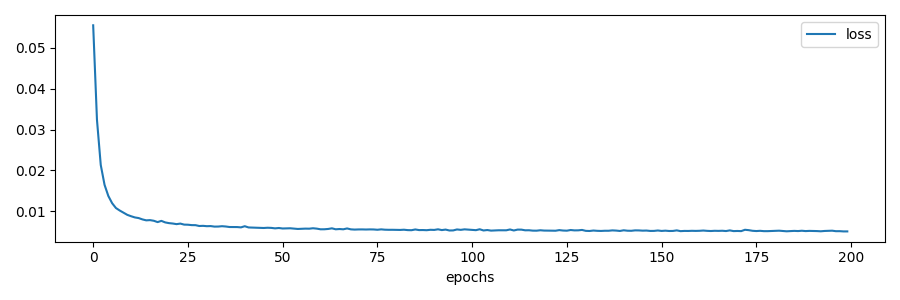

Model loss: 0.0051 (training)


In [7]:
nn = util.build_ml_model(input_size=len(attributes), output_size=1, hidden=[])
history = util.train_ml_model(nn, tr[attributes], tr[target], validation_split=0.,
                              epochs=200)
util.plot_training_history(history, figsize=figsize)

## Baseline Evaluation

**...And let's check the results**

In [8]:
tr_pred = nn.predict(tr[attributes])
r2_tr = r2_score(tr[target], tr_pred)

ts_pred = nn.predict(ts[attributes])
r2_ts = r2_score(ts[target], ts_pred)

print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')

R2 score: 0.65 (training), 0.60 (test)


* They are not super (definitely not [PreCrime](https://en.wikipedia.org/wiki/The_Minority_Report) level), but not alwful either
* Some improvements (not much) can be obtained with a Deeper model

**We will keep Linear Regression as a baseline**

## Discrimination Indexes

**Discrimination can be linked to _disparate treatment_**

* "race" _may not be even among the input attributes_
* ...And yet it may be taken into account implicitly (i.e. via correlates)

**But we can check whether the model _treats differently different groups_:**


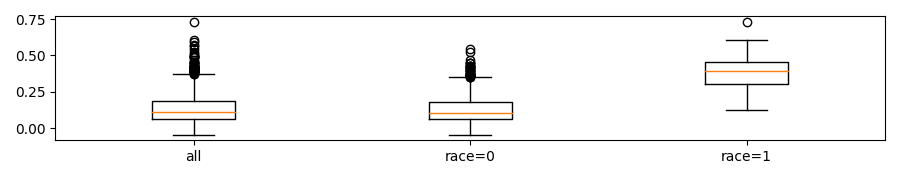

In [9]:
protected = {'race': (0, 1)}
util.plot_pred_by_protected(tr, tr_pred, protected, figsize=(figsize[0], 0.6*figsize[1]))

Indeed, our model has a significant degree of discrimination

## Discrimination Indexes

**A number of _discrimination indexes_ attempt to measure discrimination**

* Whether ethics itself can be measured is _highly debatable_!
* ...But even if imperfect, this currently the best we can do

**We will use the [Disparate Impact Discrimination Index](https://www.aaai.org/ojs/index.php/AAAI/article/download/3943/3821)**

* Given a set of categorical _protected attribute (indexes) $J_p$_
* ...The regression for of the regression form of the index ($\text{DIDI}_r$) is given by:

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* Where $D_j$ is the domain of attribute $j$
* ...And $I_{j,v}$ is the set of example such that attribute $j$ has value $v$




## DIDI

**Let's make some intuitive sense of the $\text{DIDI}_r$ formula**

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* $\frac{1}{m} \sum_{i=1}^m y_i$ is just the average predicted value
* The protected attribute defines social groups
* $\frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}$ is the average prediction for a social group

**We penalize _deviations from the global average_**

* Obviously this is not necessarily the best definition, but it is something
* In general, different tasks will call for different discrimination indexes

...And don't forget the whole "can we actually measure ethics" issue ;-)

## DIDI

**We can compute the DIDI via the following function**

```python
def DIDI_r(data, pred, protected):
    res, avg = 0, np.mean(pred)
    for aname, dom in protected.items():
        for val in dom:
            mask = (data[aname] == val)
            res += abs(avg - np.mean(pred[mask]))
    return res
```

* `protected` contains the protected attribute names with their domain

**For our original Linear Regression model, we get**

In [10]:
tr_DIDI = util.DIDI_r(tr, tr_pred, protected)
ts_DIDI = util.DIDI_r(ts, ts_pred, protected)
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

DIDI: 0.26 (training), 0.28 (test)


## Fairness Constraints

**Discrimination indexes can be used to state fairness constraints**

For example, we may require:
$$
\text{DIDI}_r(y) \leq \theta
$$

**If the chosen index is _differentiable_...**

...Then we may try to inject the constraint in a NN via a _semantic regularizer_

* For example, we may use a loss function in the form:
$$
L(y, \hat{y}) + \lambda \max(0, \text{DIDI}_r(y) - \theta)
$$

For non-differentiable indexes (e.g. those found in classification), we can:

* Use a differentiable approximation (with some care!)
* Use an approach that does not require differentiability, e.g. [this](https://arxiv.org/abs/2002.10766) or [that](https://link.springer.com/content/pdf/10.1007/s10115-011-0463-8.pdf)



## Fairness as a Semantic Regularizer

**We can once again use a custom Keras model**

```python
class CstDIDIRegressor(keras.Model):
    def __init__(self, base_pred, attributes, protected, alpha, thr): ...

    def train_step(self, data): ...

    @property
    def metrics(self): ...
```

The full code can be found in the support module

* We subclass `keras.Model` and we provide a custom training step
* `alpha` is the regularizer weight
* `thr` is the DIDI threshold

In this case, we do not need a custom batch generator

## Fairness as a Semantic Regularizer

**The main logic is in the first half of the `train_step` method:**

```python
def train_step(self, data):
    x, y_true = data # unpacking the mini-batch
    with tf.GradientTape() as tape:
        y_pred = self.based_pred(x, training=True) # obtain predictions
        mse = self.compiled_loss(y_true, y_pred) # base loss (kept external)
        ymean = k.mean(y_pred) # avg prediction
        didi = 0 # DIDI computation
        for aidx, dom in self.protected.items():
            for val in dom:
                mask = (x[:, aidx] == val)
                didi += k.abs(ymean - k.mean(y_pred[mask]))
        cst = k.maximum(0.0, didi - self.thr) # Regularizer
        loss = mse + self.alpha * cst
```

* The main loss is defined when calling `compile`

## Training the Constrained Model

**Let's try and train the model, trying to _roughly halve_ the DIDI**

* Important: it will be a good idea to need to keep all examples in every batch
* Mini-batches can be used, but make constraint satisfaction (more) stochastic

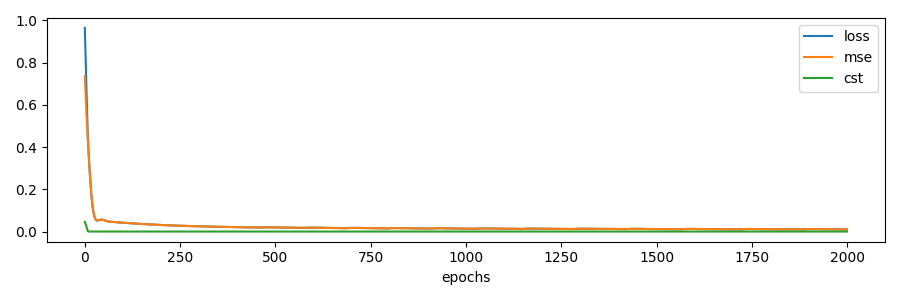

Model loss: 0.0100 (training)


In [13]:
didi_thr = 0.13
base_pred = util.build_ml_model(input_size=len(attributes), output_size=1, hidden=[])
nn2 = util.CstDIDIModel(base_pred, attributes, protected, alpha=5, thr=didi_thr)
history = util.train_ml_model(nn2, tr[attributes], tr[target], validation_split=0., epochs=2000, batch_size=len(tr))
util.plot_training_history(history, figsize=figsize)

## Constrained Model Evaluation

**Let's check both the prediction quality and the DIDI**

In [14]:
tr_pred2 = nn2.predict(tr[attributes])
r2_tr2 = r2_score(tr[target], tr_pred2)
ts_pred2 = nn2.predict(ts[attributes])
r2_ts2 = r2_score(ts[target], ts_pred2)
tr_DIDI2 = util.DIDI_r(tr, tr_pred2, protected)
ts_DIDI2 = util.DIDI_r(ts, ts_pred2, protected)

print(f'R2 score: {r2_tr2:.2f} (training), {r2_ts2:.2f} (test)')
print(f'DIDI: {tr_DIDI2:.2f} (training), {ts_DIDI2:.2f} (test)')

R2 score: 0.35 (training), 0.24 (test)
DIDI: 0.11 (training), 0.10 (test)


The constraint is satisfied _with some slack_, leading to reduced performance

* A large $\lambda$ (what we have here) slows down training 
* ...But a small $\lambda$ may lead to significant constraint violation

# Lagrangian Dual Framework

## Penalty Method

**We can think of increasing $\lambda$ gradually**

...Which leads to the classical _penalty method_

* $\lambda^{(0)} = 1$
* $\omega^{(0)} = \arg\min_{\omega} \left\{ L(y) + \lambda^{(0)T} \max(0, g(y)) \right\} \text{ with: } y = f(\hat{x}; \omega)$
* For $k = 1..n$
  - If $g(y) \leq 0$, stop
  - Otherwise $\lambda^{(k)} = r\lambda^{(k)}$, with $r \in (1, \infty)$
  - $\omega^{(k)} = \arg\min_{\omega} \left\{ L(y) + \lambda^{(k)T} \max(0, g(y)) \right\} \text{ with: } y = f(\hat{x}; \omega)$

**This is a simple, but flexible approach for constrained (numeric) optimization**

* It works even with non differentiable constraints
* ...If your training engine can handle them, that is

## Drawbacks of the Penalty Method

**The penalty method can be quite effective, but it has some _drawbacks_:**

1. You need an optimal solver
   * Without one, you only get approximate results (no guarantees)
2. The $\max$ (or square) is important
   * Without that, penalties turn into rewards for satisfied constraints
3. You may need arbitrarily large weights (and there is no way around this)

<center><img src="assets/pm_fail.png" width="550px"/></center>

## Lagrangian Dual Approach

**A nice compromise is provided by the [Lagrangian Dual approach](https://arxiv.org/pdf/2001.09394)**

We start from the fact that solving:
$$
\min_{\omega} \left\{ L(y) + \lambda^T \max(0, g(y)) \right\} \text{ with: } y = f(\hat{x}; \omega)
$$
...Always provides a _lower bound_ on the true constrained optimum

* The reason is that on the original feasible space, all penalty terms are 0
* ...And therefore the minimum cannot be worse than the original one

**Therefore, it makes sense to pick $\lambda$ so as to _maximize this bound_**

$$
\text{argmax}_{\lambda} \min_{\omega} \left\{ L(y) + \lambda^T \max(0, g(y)) \right\} \text{ with: } y = f(\hat{x}; \omega)
$$

Solving this problem given the best possible lower bound

## Lagrangian Dual Approach

**Now, let's look more carefully at our problem:**

$$\begin{align}
& \text{argmax}_{\lambda} \min_\omega \mathcal{L(\lambda, \omega)} \\
\text{where: } & \mathcal{L(\lambda, \omega)} = L(y) + \lambda^T \max(0, g(y)) \\
\text{ with: } & y = f(\hat{x}; \omega)
\end{align}$$

**This is a _bi-level optimization problem_**

It can be proved that it is _concave in $\lambda$_

* Therefore, it can be solved via _sub-gradient_ descent
* ...Even for non-differentiable $L$, $g$, and $f$

**By doing so, we increase $\lambda$ only _when and where_ it is needed**

* It is a _strong mitigation_ for the issues of the penalty method 


## Lagrangian Dual Approach

**If additionally $\mathcal{L}(\lambda, \omega)$ is differentiable in $\omega$**

...Then we can solve the problem via alternate _gradient descent/ascent_:

* $\lambda^{(0)} = 0$
* $\omega^{(0)} = \arg \min_\theta \mathcal{L}(\lambda^{(0)}, \omega)$
* For $k = 1..n$ (or until convergence):
  - Obtain $\lambda^{(k)}$ via an ascent step with sub-gradient $\nabla_{\lambda} \mathcal{L}(\lambda, \omega^{(k-1)})$
  - Obtain $\omega^{(k)}$ via a descent step with sub-gradient $\nabla_{\omega} \mathcal{L}(\lambda^{(k)}, \omega)$

**The approach is easy to implement in tensorflow/PyTorch**

We just need to use two optimization steps

* It works since small changes to $\lambda$
* ...Usually require small changes to $\omega$
* Hence, we can maintain the two vectors approximately optimal 

## Implementing the Lagrangian Dual Approach

**We will implement the Lagrangian dual approach via another custom model**

```python
class LagDualDIDIRegressor(MLPRegressor):
    def __init__(self, base_pred, attributes, protected, thr):
        super(LagDualDIDIRegressor, self).__init__()
        self.alpha = tf.Variable(0., name='alpha')
        ...

    def __custom_loss(self, x, y_true, sign=1): ...

    def train_step(self, data): ...
        
    def metrics(self): ...
```

* We no longer pass a fixed `alpha` weight/multiplier
* Instead we use a _trainable variable_

## Implementing the Lagrangian Dual Approach

**In the `__custom_loss` method we compute the Lagrangian/regularized loss**

```python
def __custom_loss(self, x, y_true, sign=1):
    y_pred = self.base_pred(x, training=True) # obtain the predictions
    mse = self.compiled_loss(y_true, y_pred) # main loss
    ymean = tf.math.reduce_mean(y_pred) # average prediction
    didi = 0 # DIDI computation
    for aidx, dom in self.protected.items():
        for val in dom:
            mask = (x[:, aidx] == val)
            didi += tf.math.abs(ymean - tf.math.reduce_mean(y_pred[mask]))
    cst = tf.math.maximum(0.0, didi - self.thr) # regularizer
    loss = mse + self.alpha * cst
    return sign*loss, mse, cst
```

* The code is the same as before
* ...Except that we can flip the loss sign via a function argument (i.e. `sign`)

## Implementing the Lagrangian Dual Approach

**In the training method, we make _two distinct gradient steps:_**

```python
    def train_step(self, data):
        x, y_true = data # unpacking
        with tf.GradientTape() as tape: # first loss (minimization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=1)
        tr_vars = self.trainable_variables
        wgt_vars = tr_vars[:-1] # network weights
        mul_vars = tr_vars[-1:] # multiplier
        grads = tape.gradient(loss, wgt_vars) # adjust the network weights
        self.optimizer.apply_gradients(zip(grads, wgt_vars))
        with tf.GradientTape() as tape: # second loss (maximization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=-1)
        grads = tape.gradient(loss, mul_vars) # adjust lambda
        self.optimizer.apply_gradients(zip(grads, mul_vars))
```

* In principle, we could even have used two distinct optimizers
* That would allow to keep (e.g.) separate momentum vectors

## Training the Lagrangian Dual Approach

**The new approach leads less oscillations at training time**

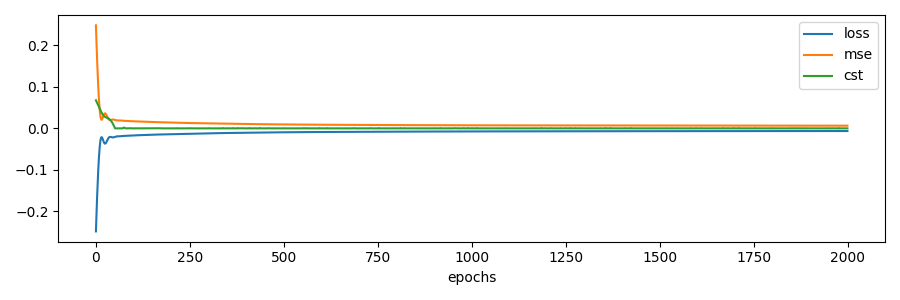

Model loss: -0.0065 (training)


In [17]:
base_pred = util.build_ml_model(input_size=len(attributes), output_size=1, hidden=[])
nn3 = util.LagDualDIDIModel(base_pred, attributes, protected, thr=didi_thr)
history = util.train_ml_model(nn3, tr[attributes], tr[target], validation_split=0.,
                              epochs=2000, batch_size=len(tr))
util.plot_training_history(history, figsize=figsize)

## Lagrangian Dual Evaluation

**Let's check the new results**

In [18]:
tr_pred3 = nn3.predict(tr[attributes])
r2_tr3 = r2_score(tr[target], tr_pred3)
ts_pred3 = nn3.predict(ts[attributes])
r2_ts3 = r2_score(ts[target], ts_pred3)
tr_DIDI3 = util.DIDI_r(tr, tr_pred3, protected)
ts_DIDI3 = util.DIDI_r(ts, ts_pred3, protected)


print(f'R2 score: {r2_tr3:.2f} (training), {r2_ts3:.2f} (test)')
print(f'DIDI: {tr_DIDI3:.2f} (training), {ts_DIDI3:.2f} (test)')

R2 score: 0.58 (training), 0.53 (test)
DIDI: 0.13 (training), 0.13 (test)


* The DIDI has the desired value (on the test set, this is only roughly true)
* ...And the prediction quality is _much higher than before_!

## Some References

* Michelangelo Diligenti, Marco Gori, Claudio Saccà: Semantic-based regularization for learning and inference. Artif. Intell. 244: 143-165 (2017)
* Francesco Giannini, Michelangelo Diligenti, Marco Gori, Marco Maggini: On a Convex Logic Fragment for Learning and Reasoning. IEEE Trans. Fuzzy Syst. 27(7): 1407-1416 (2019)
* Badreddine, Samy, et al. "Logic tensor networks." Artificial Intelligence 303 (2022): 103649.
* Serafini, Luciano, and Artur d'Avila Garcez. "Logic tensor networks: Deep learning and logical reasoning from data and knowledge." arXiv preprint arXiv:1606.04422 (2016).
* Mattia Silvestri, Michele Lombardi, Michela Milano: Injecting Domain Knowledge in Neural Networks: A Controlled Experiment on a Constrained Problem. CPAIOR 2021: 266-282

## Some References

* Boyd, Stephen, Stephen P. Boyd, and Lieven Vandenberghe. Convex optimization. Cambridge university press, 2004.
* Andrew Cotter, Heinrich Jiang, Maya R. Gupta, Serena Wang, Taman Narayan, Seungil You, Karthik Sridharan: Optimization with Non-Differentiable Constraints with Applications to Fairness, Recall, Churn, and Other Goals. J. Mach. Learn. Res. 20: 172:1-172:59 (2019)
* Ferdinando Fioretto, Pascal Van Hentenryck, Terrence W. K. Mak, Cuong Tran, Federico Baldo, Michele Lombardi: Lagrangian Duality for Constrained Deep Learning. ECML/PKDD (5) 2020: 118-135
* Berk, R.; Heidari, H.; Jabbari, S.; Joseph, M.; Kearns, M. J.; Morgenstern, J.; Neel, S.; and Roth, A. 2017. A Convex Framework for Fair Regression. CoRR abs/1706.02409. URL http://arxiv.org/abs/1706.02409